# 3.4 Classifying movie reviews: a binary classification example

Two-class classification, or binary classification, may be the most widely applied kind
of machine-learning problem. In this example, you’ll learn to classify movie reviews as
positive or negative, based on the text content of the reviews.

## 3.4.1 The IMDB dataset

You’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the
Internet Movie Database. They’re split into 25,000 reviews for training and 25,000
reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Why use separate training and test sets? Because you should never test a machinelearning
model on the same data that you used to train it! Just because a model performs
well on its training data doesn’t mean it will perform well on data it has never
seen; and what you care about is your model’s performance on new data (because you
already know the labels of your training data—obviously you don’t need your model
to predict those). For instance, it’s possible that your model could end up merely memorizing
a mapping between your training samples and their targets, which would be
useless for the task of predicting targets for data the model has never seen before.
We’ll go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has
already been preprocessed: the reviews (sequences of words) have been turned into
sequences of integers, where each integer stands for a specific word in a dictionary.
The following code will load the dataset (when you run it the first time, about
80 MB of data will be downloaded to your machine).

In [1]:
# Loading the IMDB dataset
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


The argument num_words=10000 means you’ll only keep the top 10,000 most frequently
occurring words in the training data. Rare words will be discarded. This allows
you to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews; each review is a list of
word indices (encoding a sequence of words). train_labels and test_labels are
lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [2]:
# reviews = avis => sequence de mots
# train_data[0] instance of reviews

In [3]:
train_labels[0]

1

Because you’re restricting yourself to the top 10,000 most frequent words, no word
index will exceed 10,000:

In [4]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here’s how you can quickly decode one of these reviews back to English
words:

In [5]:
# word_index is a dictionary mapping words to an integer index.
word_index = imdb.get_word_index()

In [6]:
# Reverses it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [7]:
# Decodes the review. Note that the indices
# are offset by 3 because 0, 1, and 2 are
# reserved indices for “padding,” “start of
# sequence,” and “unknown.”
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

## 3.4.2 Preparing the data

You can’t feed lists of integers into a neural network. You have to turn your lists into
tensors. There are two ways to do that:

* Pad your lists so that they all have the __same length__, turn them into an integer tensor of shape __(samples, word_indices)__, and then use as the first layer in your network a layer capable of handling such integer tensors (the __Embedding layer__, which we’ll cover in detail later in the book).
* __One-hot encode__ your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for
maximum clarity.

In [8]:
# Encoding the integer sequences into a binary matrix
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    # Creates an all-zero matrix of shape (len(sequences),dimension)
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        # Sets specific indices of results[i] to 1s
        #print('i ', i, ' sequence ', sequence)
        results[i, sequence] = 1.
    return results

In [9]:
train_data.shape

(25000,)

In [10]:
x_train = vectorize_sequences(train_data)

In [11]:
np.array_equal(x_train[1], x_train[2])

False

In [12]:
x_test = vectorize_sequences(test_data)

You should also vectorize your labels, which is straightforward:

In [13]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now the data is ready to be fed into a neural network.

## 3.4.3 Building your network

The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup
you’ll ever encounter. A type of network that performs well on such a problem is
a simple stack of fully connected ( Dense ) layers with relu activations: Dense(16,
activation='relu').

The argument being passed to each Dense layer (16) is the number of hidden
units of the layer. A hidden unit is a dimension in the representation space of the layer.
You may remember from chapter 2 that each such Dense layer with a relu activation
implements the following chain of tensor operations:

In [14]:
# output = relu(dot(W, input) + b)

Having 16 hidden units means the weight matrix W will have shape (input_dimension, 16).

There are two key architecture decisions to be made about such a stack of Dense layers:
* How many layers to use
* How many hidden units to choose for each layer

In chapter 4, you’ll learn formal principles to guide you in making these choices. For
the time being, you’ll have to trust me with the following architecture choice:
* Two intermediate layers with 16 hidden units each
* A third layer that will output the scalar prediction regarding the sentiment of the current review

And here’s the Keras implementation, similar to the MNIST example you saw previously.

In [15]:
# The model definition
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


Finally, you need to choose a loss function and an optimizer. Because you’re facing a
binary classification problem and the output of your network is a probability (you end
your network with a single-unit layer with a sigmoid activation), it’s best to use the
__binary_crossentropy__ loss. It isn’t the only viable choice: you could use, for instance,
__mean_squared_error__. But crossentropy is usually the best choice when you’re dealing
with models that output probabilities. __Crossentropy__ is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this
case, between the ground-truth distribution and your predictions.
 Here’s the step where you configure the model with the __rmsprop__ optimizer and
the __binary_crossentropy__ loss function. Note that you’ll also monitor accuracy
during training.

In [16]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

You’re passing your optimizer, loss function, and metrics as strings, which is possible
because rmsprop, binary_crossentropy, and accuracy are packaged as part of Keras.
Sometimes you may want to configure the parameters of your optimizer or pass a custom loss function or metric function. The former can be done by passing an optimizer
class instance as the optimizer argument, as shown in listing below; the latter can be
done by passing function objects as the loss and/or metrics arguments, as shown in
listing below.

In [17]:
# Configuring the optimizer
# from keras import optimizers
# model.compile(optimizer=optimizers.RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
# Using custom losses and metrics
# from keras import losses, metrics
# model.compile(optimizer=optimizers.RMSprop(lr=0.001),
# loss=losses.binary_crossentropy,
# metrics=[metrics.binary_accuracy])

## 3.4.4 Validating your approach

In order to monitor during training the accuracy of the model on data it has never
seen before, you’ll create a validation set by setting apart 10,000 samples from the
original training data.

In [19]:
# Setting aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

You’ll now train the model for 20 epochs (20 iterations over all samples in the
x_train and y_train tensors), in mini-batches of 512 samples. At the same time,
you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by
passing the validation data as the validation_data argument.

In [20]:
# Training your model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.5084 - acc: 0.7815 - val_loss: 0.3795 - val_acc: 0.8690
Epoch 2/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.3005 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8902
Epoch 3/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.2179 - acc: 0.9287 - val_loss: 0.3086 - val_acc: 0.8712
Epoch 4/20
15000/15000 [==============================] - 1s 81us/step - loss: 0.1750 - acc: 0.9436 - val_loss: 0.2840 - val_acc: 0.8833
Epoch 5/20
15000/15000 [==============================] - 1s 77us/step - loss: 0.1427 - acc: 0.9544 - val_loss: 0.2841 - val_acc: 0.8869
Epoch 6/20
15000/15000 [==============================] - 1s 79us/step - loss: 0.1150 - acc: 0.9652 - val_loss: 0.3149 - val_acc: 0.8776
Epoch 7/20
15000/15000 [==============================] - 1s 78us/step - loss

Note that the call to __model.fit()__ returns a __History__ object. This object has a member history, which is a __dictionary__ containing data about everything that happened
during training. Let’s look at it:

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

The dictionary contains four entries: one per metric that was being monitored during
training and during validation. In the following two listing, let’s use Matplotlib to plot
the training and validation loss side by side, as well as the training and
validation accuracy. Note that your own results may vary slightly due to
a different random initialization of your network.

In [22]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.history

acc = history_dict['acc']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo” is for “blue dot.”
plt.plot(epochs, loss_values, 'bo', label='Training loss')
# “b” is for “solid blue line.”
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

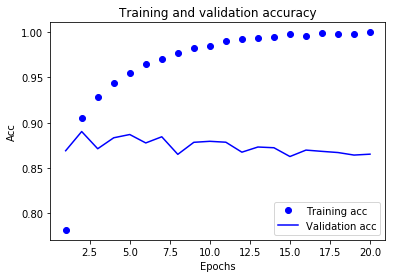

In [23]:
# Plotting the training and validation accuracy
# Clears the figure
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradientdescent optimization—the quantity you’re trying to minimize should be less with
every iteration. But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch. This is an example of what we warned against earlier: a
model that performs better on the training data isn’t necessarily a model that will do
better on data it has never seen before. In precise terms, what you’re seeing is __overfitting__: after the second epoch, you’re overoptimizing on the training data, and you end
up learning representations that are specific to the training data and don’t generalize
to data outside of the training set.
 
In this case, to prevent overfitting, you could stop training after three epochs. In
general, you can use a range of techniques to mitigate overfitting, which we’ll cover in
chapter 4.
 
Let’s train a new network from scratch for four epochs and then evaluate it on the
test data.

In [24]:
# Retraining a model from scratch
model = models.Sequential()

model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 64us/step - loss: 0.4742 - acc: 0.8221
Epoch 2/4
25000/25000 [==============================] - 1s 54us/step - loss: 0.2635 - acc: 0.9101
Epoch 3/4
25000/25000 [==============================] - 1s 55us/step - loss: 0.1986 - acc: 0.9309
Epoch 4/4
25000/25000 [==============================] - 2s 67us/step


In [25]:
results

[0.3229699110984802, 0.87288]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art
approaches, you should be able to get close to 95%.

## 3.4.5 Using a trained network to generate predictions on new data

After having trained a network, you’ll want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the __predict__ method:

In [26]:
model.predict(x_test)

array([[0.13631961],
       [0.99970657],
       [0.28467682],
       ...,
       [0.07529172],
       [0.0455606 ],
       [0.49371928]], dtype=float32)

As you can see, the network is confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).

## 3.4.6 Further experiments

The following experiments will help convince you that the architecture choices you’ve
made are all fairly reasonable, although there’s still room for improvement:
* You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.
* Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.
* Try using the __mse__ loss function instead of __binary_crossentropy__.
* Try using the __tanh__ activation (an activation that was popular in the early days of neural networks) instead of __relu__.

## 3.4.7 Wrapping up

Here’s what you should take away from this example:
* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
* Stacks of __Dense__ layers with __relu__ activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently
* In a binary classification problem (two output classes), your network should end with a __Dense__ layer with one unit and a __sigmoid__ activation: the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output on a binary classification problem, the loss function you should use is __binary_crossentropy__.
* The __rmsprop__ optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set. 